In [2]:
#Modules and Importing Data

!pip install pystan
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pystan
import pandas as pd
from google.colab import files
from datetime import datetime
import datetime as dt

files.upload() 

Saving weekly_in_situ_co2_mlo.csv to weekly_in_situ_co2_mlo (6).csv


{'weekly_in_situ_co2_mlo.csv': b'Date,PPM\r\n29/03/1958,316.19\r\n05/04/1958,317.31\r\n12/04/1958,317.69\r\n19/04/1958,317.58\r\n26/04/1958,316.48\r\n03/05/1958,316.95\r\n17/05/1958,317.56\r\n24/05/1958,317.99\r\n05/07/1958,315.85\r\n12/07/1958,315.85\r\n19/07/1958,315.46\r\n26/07/1958,315.59\r\n02/08/1958,315.64\r\n09/08/1958,315.1\r\n16/08/1958,315.09\r\n30/08/1958,314.14\r\n06/09/1958,313.54\r\n08/11/1958,313.05\r\n15/11/1958,313.26\r\n22/11/1958,313.57\r\n29/11/1958,314.01\r\n06/12/1958,314.56\r\n13/12/1958,314.41\r\n20/12/1958,314.77\r\n27/12/1958,315.21\r\n03/01/1959,315.24\r\n10/01/1959,315.5\r\n17/01/1959,315.69\r\n24/01/1959,315.86\r\n31/01/1959,315.42\r\n14/02/1959,316.94\r\n21/02/1959,316.61\r\n28/02/1959,316.62\r\n07/03/1959,316.81\r\n21/03/1959,316.73\r\n28/03/1959,316.71\r\n04/04/1959,317.72\r\n11/04/1959,317.12\r\n18/04/1959,317.64\r\n25/04/1959,318.32\r\n02/05/1959,318.27\r\n09/05/1959,318.78\r\n16/05/1959,318.05\r\n23/05/1959,318.43\r\n06/06/1959,318.53\r\n13/06/1959,3

In [8]:
#Importing Data and Removing NAs

data = pd.read_csv('weekly_in_situ_co2_mlo.csv')
data = data.dropna()

#Current measurement dates processing for Stan - I made each measurement represent a week away from the first measurement, so 1 is the first measurement, 2 represents the measurement taken the week after
#The ordinal time helped to uncomplicate the processing involved, concerning in the weeks that data was not collected.

d_n = pd.to_datetime(data['Date'], format='%d/%m/%Y').map(dt.datetime.toordinal)
d = [int(((d_n[i]- d_n[0])+7)/7) for i in range(len(d_n))]


#Future dates list processing for Stan
future_dates=pd.date_range(start='2018-11-03', end='2058-01-01', freq='W-SAT',closed=None) #Getting range of future dates

f =[]
for i in range(len(d)):
  if i==0:
    date=d[-1]+1
    f.append(date)
  else:
    date+=1
    f.append(date)
  i+=1
  
f = f[:len(future_dates)]
#This part looks longer because I previously planned to use minmaxscaler on the data.
  
#Original PPM data  
d_ppm =list(data['PPM'])



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [10]:
#This is the Stan Code I used - it is a modified version of the code we used in session 14.1. The parameters were gotten from likelihood function which
#I modified from the example given to us in Assignment description. The transformation is in line with code from session 14.1

stan_code = '''
data {
int<lower=0> N; // length of current dates
real ppm[N]; // Original CO2 levels in ppm
real t[N]; // timesteps for current dates
int<lower=0> N_future; //length of futuredates
real t_future[N_future]; // timesteps for future dates
}

parameters {
real<lower=0> c0;
real<lower=0> c1;
real<lower=0> c2;
real<lower=0> c3;
real<lower=0> c4_x;
real<lower=0> c4_y;
real<lower=0> c5;
}

transformed parameters {
    real<lower=0,upper=1> c4;

    // The atan2 function returns a value in the range [-pi, pi], which we
    // then transform linearly into the range [0, 1].
    c4 = atan2(c4_x, c4_y);
}

//Justification of priors choice done in paper
model {
c0 ~ normal(300,1); 
c1 ~ normal(0.1,1); 
c2 ~ normal(0.1,1);
c3 ~ normal(3,0.5);
c4_x ~ normal(0,1);
c4_y ~ normal(0,1); 
c5 ~ normal(2,0.5);


for(n in 1:N) {
  ppm[n] ~ normal(c0 + c1*t[n] + c2*t[n]*t[n] + c3*cos(2*3.14*t[n]/52 + c4),c5);
  }
}

//Generated quantities block - Used to generate future CO2 ppm predictions

generated quantities {
  real ppm_future[N_future]; // future co2 levels
  for(n in 1:N_future) {
    ppm_future[n] = normal_rng(c0 + c1*t_future[n] + c2*t_future[n]*t_future[n] + c3*cos(2*3.14*t_future[n]/52 + c4), c5);
  }
}
'''
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3d66a48201767f3eef1d88f094e7dd03 NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpwltucjfg/stanfit4anon_model_3d66a48201767f3eef1d88f094e7dd03_5044110529928967619.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [0]:
#Data going into Stan model
stan_data = {
    'N': len(d),
    'ppm': d_ppm,
    'N_future': len(f),
     't': d,
     't_future': f}  

In [0]:
#Running Stan model
results = stan_model.sampling(data=stan_data)
samples = results.extract()

In [54]:
#Hyperparameter results and CI

parameters = ['c0','c1','c2','c3','c4','c5']
print(results.stansummary(pars=parameters, probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_3d66a48201767f3eef1d88f094e7dd03.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

     mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
c0  314.3  2.3e-3   0.12 314.07  314.3 314.53   2533    1.0
c1   0.02  3.6e-6 1.7e-4   0.01   0.02   0.02   2108    1.0
c2 4.6e-6  1.1e-9 5.1e-8 4.5e-6 4.6e-6 4.7e-6   2127    1.0
c3   1.22  9.9e-4   0.05   1.11   1.22   1.32   2783    1.0
c4 9.4e-4  1.5e-5 9.3e-4 2.5e-5 6.5e-4 3.4e-3   3632    1.0
c5   2.08  4.7e-4   0.03   2.03   2.08   2.13   3208    1.0

Samples were drawn using NUTS at Fri Dec 21 20:38:48 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


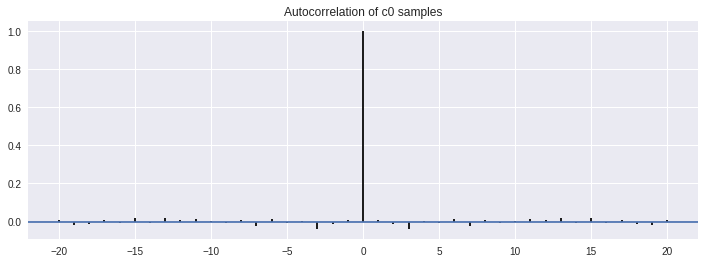

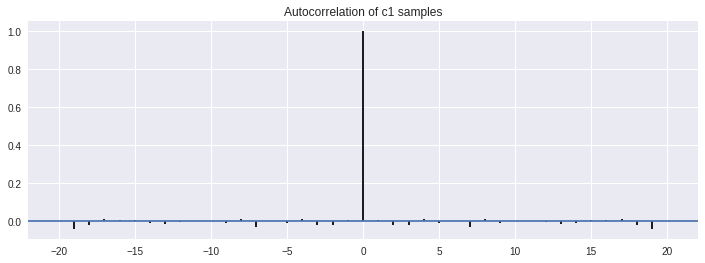

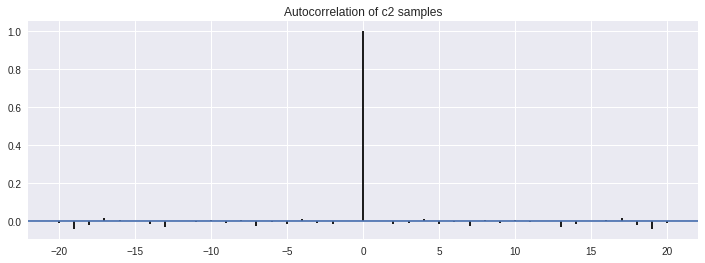

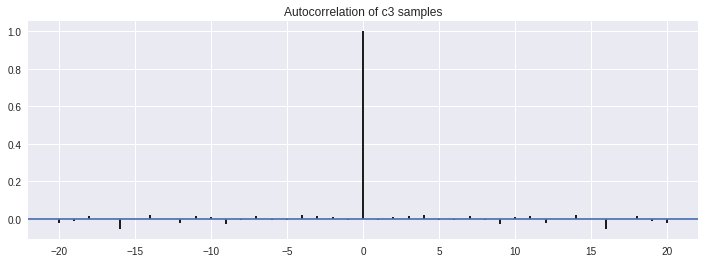

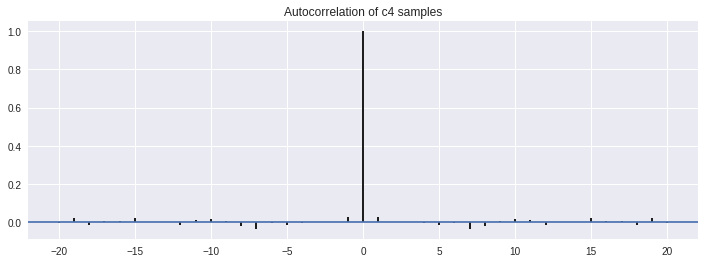

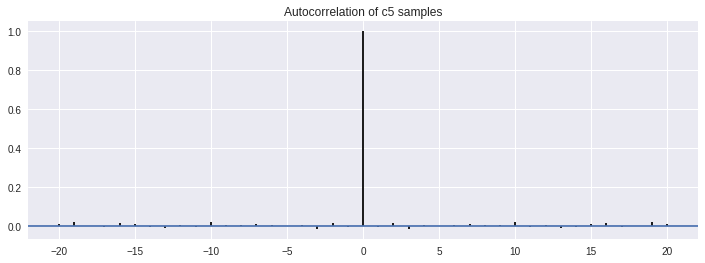

In [13]:
#Correlation plots

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()


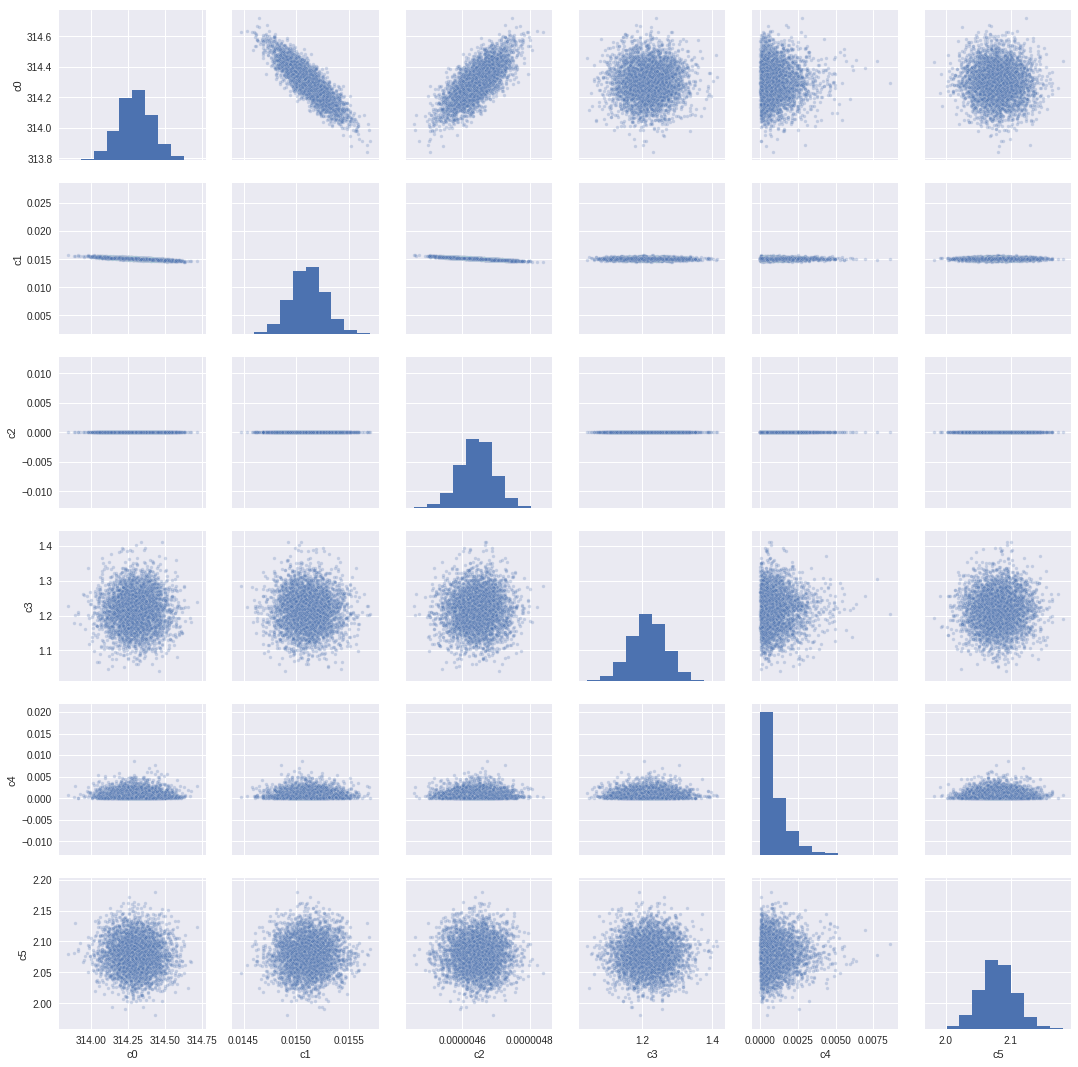

In [14]:
#Pairwise plots

import seaborn

df = pd.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [0]:
#Getting the results from Stan
a = results["ppm_future"]
a = np.transpose(a) #to make getting mean and CIs easier

#Getting the mean and CI predictions from Stan
mean_f = [np.mean(i) for i in a]
lb_f = [np.percentile(i,2.5) for i in a]
ub_f = [np.percentile(i,97.5) for i in a]

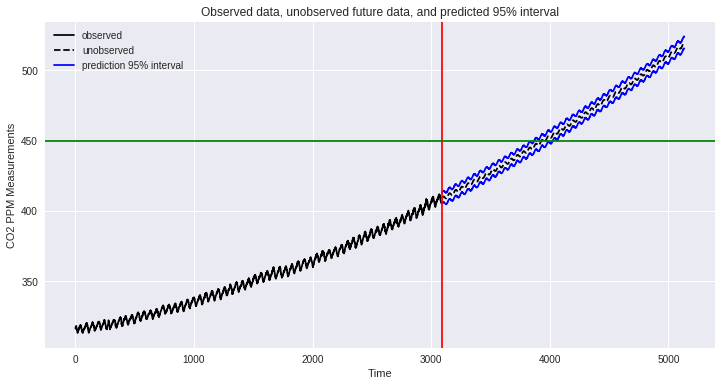

In [48]:
# Plot mean and 95% interval of future predictions
n= len(d)
n_future = len(f)

plt.figure(figsize=(12, 6))
plt.plot(range(1, n + 1), d_ppm, 'k-', label='observed')
plt.plot(range(n, n + n_future ),mean_f, 'k--', label='unobserved')
plt.plot(range(n, n + n_future ),lb_f, 'b-', label='prediction 95% interval')
plt.plot(range(n, n + n_future ),ub_f, 'b-')
plt.axvline(n - 1, color='red')
plt.axhline(450, color='green')
plt.xlabel('Time')
plt.ylabel('CO2 PPM Measurements')
plt.legend()
plt.title('Observed data, unobserved future data, and predicted 95% interval')
plt.show()

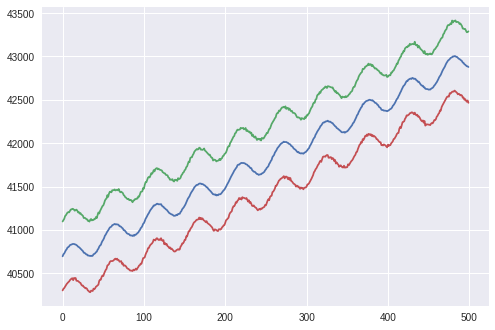

In [23]:
#Subsetted graph to show confidence intervals for future predictions are not as small as they look
plt.plot(s_mean_f[:500], label = 'Mean')
plt.plot(s_ub_f[:500], label = 'Upper CI Bound')
plt.plot(s_lb_f[:500],label = 'Lower CI Bound')
plt.legend()

CO2 levels of 450 ppm is considered high risk for dangerous climate change. By when is
there a strong probability that will we reach those levels? Use your model to answer this
question, but present the results in a way that someone unfamiliar with statistics will
understand.

In [0]:
#Changing the lists of mean and CI to arrays
mmm = np.array(mean_f )
mmm_lb = np.array(lb_f)
mmm_ub = np.array(ub_f)

In [53]:
print('2.5% chance of seeing 450pm CO2:',future_dates[np.where(mmm_ub > 450.0)[0][0]])
print('50% chance of seeing 450pm CO2:',future_dates[np.where(mmm > 450.0)[0][0]])
print('97.5% chance of seeing 450pm CO2:',future_dates[np.where(mmm_lb > 450.0)[0][0]])

2.5% chance of seeing 450pm CO2: 2033-10-08 00:00:00
50% chance of seeing 450pm CO2: 2034-11-25 00:00:00
97.5% chance of seeing 450pm CO2: 2036-10-04 00:00:00
